# A Probability Problem and a Bandit Problem

Write code in the cells indicated, and answer the questions as indicated.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import ipywidgets as widgets
from IPython.display import display, clear_output

### What Averaging Does to Noise

Suppose $X_1(t), X_2(t), \ldots, X_n(t) \sim \mathcal{N}(0, 1)$ are independent sources of independent Gaussian random variables, each producing a new random number every time step $t$.

Each $X_i$ corresponds to a different gambler, and each $X_i(t)$ corresponds to that gambler's reward at time $t$. In this simplified setting, all the gamblers are playing the same machine.

Plot $X_1(t)$ for times $t = 1, 2, \ldots, 100$. 

-0.008141648821834485


<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/s_/7q2wxzv15kn20hbn7b_lbd9m0000gn/T/ipykernel_43493/3448716404.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Sample Path of $X_1(t)$ ($\mathcal{N}(0, 1)$) for $t=1$ to $100$')


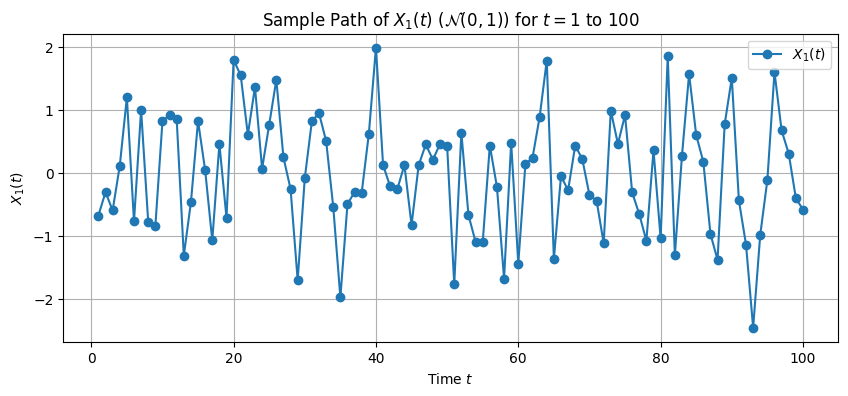

In [9]:
# your code here

X1 = np.random.normal(0, 1, 100) # vector to represent X_1(t) for t = 1-100
print(np.mean(X1)) # close to zero (for example: 0.022776981..)

# plotting
plt.figure(figsize=(10, 4))
plt.plot(range(1, 101), X1, marker='o', linestyle='-', label='$X_1(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$X_1(t)$')
plt.title('Sample Path of $X_1(t)$ ($\mathcal{N}(0, 1)$) for $t=1$ to $100$')
plt.grid(True)
plt.legend()
plt.show()

The plot illustrates the *variance* of $X_1 \sim \mathcal{N}(0, 1)$. Variance measures how much a random variable deviates from its mean. The usual formula is expected squared distance from the mean: $Var(X_1) = E(X_1 - EX_1)^2$. Since $X_1$ has mean $0$, $Var(X_1) = EX^2_1$.

#### Variance of the average of independent random variables

The average is 
$$
\bar{X} = \frac{X_1 + \cdots X_n}{n}
$$

Two of the rules of probability are
1. *Linearity of expectation*: for any random variables $Y_1, \ldots, Y_n$, $E(Y_1 + \cdots + Y_n) = E(Y_1) + \cdots + E(Y_n)$.
2. *Independence*: for independent random variables $Y$ and $Z$, $E(YZ) = E(Y)E(Z)$.

**Show** using these rules and algebra that
$$
Var(\bar{X}) = \frac{1}{n}Var(X_1).
$$

[If you get stuck, try showing this for $n=2$.]

**Answer**:

from the formula before, Variance of $\bar{X}$ is
$$
Var(\bar{X}) = E[(\bar{X}-E[\bar{X}])^2].
$$
and we will show how it is : 
$$
Var(\bar{X}) = \frac{1}{n}Var(X_1).
$$ 
given $Var(X_1) = EX^2_1$

We showed above that the mean of a standard normal is 0. So, we can simplify the variance equation to:
$$
Var(\bar{X}) = E[(\bar{X}-0)^2]. = E[(\bar{X})^2]
$$
due to rule of linearity of expectation: 
$$
E[(\bar{X})^2] = E[(\frac{X_1 + \cdots X_n}{n})^2] = (\frac{1}{n})^2*E[(X_1 + \cdots X_n)^2] = (\frac{1}{n})^2*n*E[X^2_1]
$$

$$
Var(\bar{X}) = E[(\bar{X})^2] = \frac{1}{n}Var(X_1).
$$

#### Plot of the average of independent random variables

Choose $n=100$. 

Plot $\bar{X}(t)$ in the next cell. Eyeball this plot and the previous plot. You may also go back and take statistics of the datasets plotted.

**Question**: Do the plots confirm the calculation? Make your answer quantitative.

**Answer**:

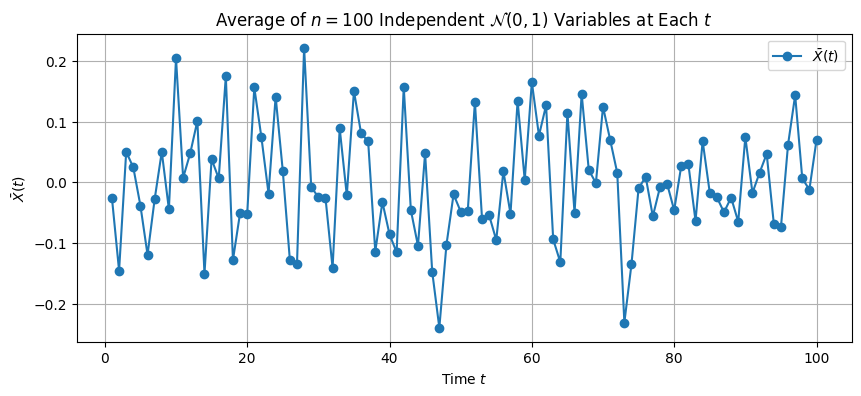

Std of single gambler (X1): 0.9036161766446296
Std of average (X_bar): 0.09334630207984669


In [10]:
# your code here 

# Plot the average of n=100 independent Gaussian random variables at each time t=1..100
np.random.seed(42)
n = 100
X = np.random.normal(0, 1, (n, 100))
X_bar = X.mean(axis=0)  # average across gamblers for each t

plt.figure(figsize=(10, 4))
plt.plot(range(1, 101), X_bar, marker='o', linestyle='-', label=r'$\bar{X}(t)$')
plt.xlabel('Time $t$')
plt.ylabel(r'$\bar{X}(t)$')
plt.title(r'Average of $n=100$ Independent $\mathcal{N}(0,1)$ Variables at Each $t$')
plt.grid(True)
plt.legend()
plt.show()

# Optional: Print standard deviations to compare
print("Std of single gambler (X1):", np.std(X[0]))
print("Std of average (X_bar):", np.std(X_bar))

### What the UCBAgent Sees

Visualize the numbers the UCBAgent uses to make its decisions

In [13]:
import sys
import os
import inspect

#module_path = os.path.abspath('RlGlue') 
#sys.path.insert(0, module_path) 

from rlglue.rl_glue import RLGlue
from main_agent import Agent
from five_arm_env import Environment

import jupyturtle as jt

#### Some illustration of jupyturtle graphics

In [14]:
sc_width=800
sc_height=200
unit = 100
numticks = (sc_width - unit) // unit

jt.make_turtle(animate=False, height=sc_height, width=sc_width)
jt.set_color("black")
jt.hide()

# draw tickmark and return to origin facing east
def draw_tick(num, color):
    jt.set_color(color)
    jt.jump_to(sc_width//2 + num*unit, sc_height//2)
    jt.left(90)
    jt.fd(unit/10)
    jt.right(90)
    jt.jump_to(sc_width//2, sc_height//2)
    jt.draw()

# draw small circle and return to origin facing east
def draw_circle(num, color, offset=0):
    jt.set_color(color)
    jt.jump_to(sc_width//2 + num*unit, sc_height//2 + offset)
    for i in range(360):
        jt.forward(.1)
        jt.left(1)
    jt.jump_to(sc_width//2, sc_height//2)
    jt.draw()

# draw x-axis
def draw_x_axis():
    jt.set_color("black")
    jt.jump_to(sc_width//2 - 4*unit, sc_height//2)
    for i in range(numticks):
        jt.forward(unit)
        jt.right(90)
        jt.forward(unit//20)
        jt.back(unit//20)
        jt.left(90)
    jt.forward(unit)
    jt.jump_to(sc_width//2, sc_height//2)
    jt.draw()
    
draw_x_axis() 
draw_tick(-1, "orange")
draw_tick(2, "green")
draw_circle(0, "blue", unit//5)

In [18]:
# Code adapted from University of Alberta Reinforcement Learning Coursera course.

def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        if q_values[i] > top_value:
            ties = [i]
            top_value = q_values[i]
        elif q_values[i] == top_value:
            ties.append(i)
        
    return np.random.choice(ties)

In [19]:
# 5-armed bandit UCB agent

class UCBAgentDG(Agent):
    def __init__(self):
        super().__init__(5)
        self.c = 0.0
        
    # note: main_agent.agent_init() now resets arm_count
    def agent_init(self, agent_info={}):
        super().agent_init(agent_info)
        self.c = agent_info.get("c", 0.0)

    def agent_step(self, reward, observation=None, extra=None):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        a = self.last_action
        self.arm_count[a] += 1
        step_size = 1.0/self.arm_count[a]
        self.q_values[a] = self.q_values[a] + step_size*(reward - self.q_values[a])
        
        t = np.sum(self.arm_count) + 1
        cb = self.c * np.sqrt(np.log(t)/np.maximum(.1,self.arm_count))
        
        current_action = argmax(self.q_values + cb)        
    
        self.last_action = current_action
        
        return current_action
 

#### Run the UCBAgent

Visualize the $q$-values and upper confidence bounds after every 5 steps

In [ ]:
# Fill in this UCBAgent experiment code to visualize the q-values and upper confidence bounds
from sympy import pretty_print #  run pip install sympy

num_runs = 1                    # The number of times we run the experiment
num_steps = 30                  # The number of pulls of each arm the agent takes
np.random.seed(0)                 # For some reason successive runs give the same arms!?
env = Environment()               # We set what environment we want to use to test
ucbAgent = UCBAgentDG()       # We choose what agent we want to use
env.env_init({})                # We pass the environment the information it needs. In this case nothing.
best_possible = np.max(env.arms)
best_arm = np.argmax(env.arms)
pretty_print(env.arms)
colors = ["blue", "orange", "green", "red", "purple"]

ucbRewards = np.zeros((num_runs, num_steps))
ucbOptimal = np.zeros((num_runs, num_steps))
for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
    np.random.seed(run)                     # the environment behaves differently each run
    ucbAgent.agent_init({"num_actions": 5,    # greedy pessimistic agent with 10 arms
                         "initial_value": 5.0})      
    
    ucbRlGlue = RLGlue(ucbAgent, env)      # new RLGlue experiment with the env and greedy agent
    ucbRlGlue.rl_start()                         # We start the experiment
        
    for i in range(num_steps):
        interaction = ucbRlGlue.rl_step()        # The environment and agent take a step and return
        ucbRewards[run, i] = interaction.r    # the reward
        ucbOptimal[run, i] = 100 if interaction.a == best_arm else 0

    if i%5 == 0 and i > 0:
        ## visualize the q-values and upper confidence bounds
        

[1.76405235 0.40015721 0.97873798 2.2408932  1.86755799]


100%|██████████| 1/1 [00:00<00:00, 534.51it/s]
